In [1]:
import pandas as pd
import numpy as np
import yaml
import pickle
import logging
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import country_converter as coco
from utilities.utilities import read_ac_data, read_gdp_data, read_cdd_data, saturation, availability, exposure_function, fill_missing_country_gdp_data
from utilities.plotting import plot_exposure_contour

In [2]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Set logging level
logging.basicConfig(level=config["logging_level"])

In [3]:
# Read the cooling degree days data
dd_data = read_cdd_data(config['ref_year'], config['cdd_historical_file'])

# Read the GDP data
gdp_data = read_gdp_data(str(config['ref_year']), config['gdp_historical_file'])
gdp_data = fill_missing_country_gdp_data(config['ref_year'], gdp_data, config)

# Merge the two dataframes
merged_data = pd.merge(dd_data, gdp_data, on='ISO3')

In [4]:
# Values from the papers https://escholarship.org/uc/item/64f9r6wr and https://doi.org/10.1016/j.enpol.2008.09.051

infl_factor = 1.65
a_avail_paper, b_avail_paper = 4.152, -0.237*infl_factor/1000
a_sat_paper, b_sat_paper, c_sat_paper = 1.0, 0.949, 0.00187

def exposure_paper_parameters(gdp, cdd):
    return exposure_function(gdp, a_avail_paper, b_avail_paper, cdd, a_sat_paper, b_sat_paper, c_sat_paper)

In [5]:
# Add AC column to merged_data
ac_data = pd.read_csv(config['ac_historical_file_iea'], skiprows=3)
# Name first column ISO3 and second column AC
ac_data = ac_data.rename(columns={ac_data.columns[0]: "ISO3", ac_data.columns[1]: "AC"})
# Rename country names to ISO3
ac_data["ISO3"] = coco.convert(names=ac_data["ISO3"].tolist(), to='ISO3')
# AC Given in percent
ac_data["AC"] /= 100.

# Merge the two dataframes
merged_data = pd.merge(merged_data, ac_data, on='ISO3', how='outer')

# Save AC data as csv]
merged_data.to_csv('data_experiencedT/AC_data.csv', index=True)

KeyError: 'ac_historical_file'

In [ ]:
ac_data = read_ac_data('data_experiencedT/AC_data.csv')

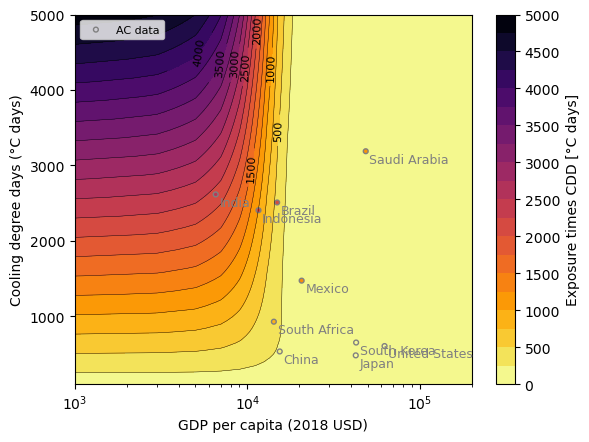

In [ ]:
plot_exposure_contour(config, exposure_paper_parameters, ac_data, x_y_ranges=[[100, 5000, 100],[1000, 200000, 100]], country=None, name_tag='exposure_contour', control=True)

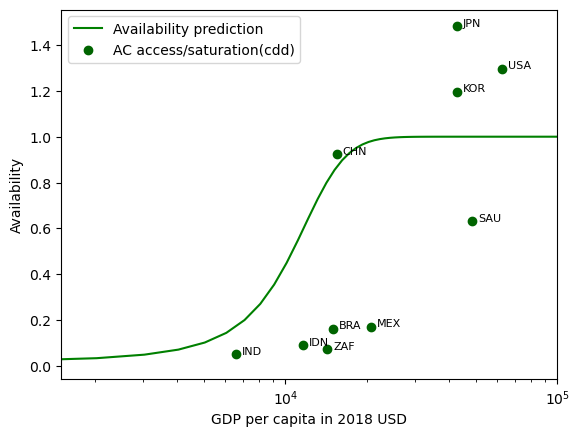

In [ ]:
# Assuming saturation is true, plot availability as a function of GDP per capita
# Add column to AC data for saturation based on DD_mean
ac_data['sat_calc'] = saturation(ac_data['DD_mean'], a_sat_paper, b_sat_paper, c_sat_paper)
# Compute availability as exposure/saturation
ac_data['avail_pred'] = ac_data['AC']/ac_data['sat_calc']
# Plot availability curve and data points
plt.close()
plt.figure()
gdp_x = np.linspace(0, 100000, 100)
plt.plot(gdp_x, availability(gdp_x, a_avail_paper, b_avail_paper), label='Availability prediction', color='green')
plt.scatter(ac_data['GDP'], ac_data['avail_pred'], label='AC access/saturation(cdd)', color='darkgreen')
# Label each point with country name
for i, txt in enumerate(ac_data['ISO3'].values):
    plt.annotate(txt, (ac_data['GDP'][i]*1.05, ac_data['avail_pred'][i]), fontsize=8)
plt.xlabel('GDP per capita in 2018 USD')
# GDP log scale
plt.xscale('log')
plt.xlim(1500, 100000)
plt.ylabel('Availability')
plt.legend()
plt.savefig('Figures/exposure_funct_analysis/availability.png', dpi=300)

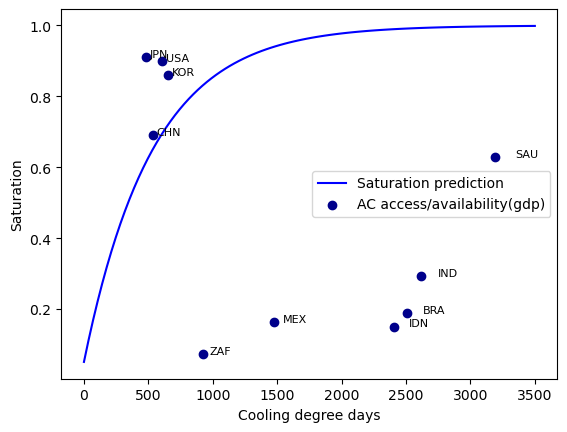

In [ ]:
# Assuming availability is true, plot saturation as a function of cooling degree days
ac_data['avail_calc'] = availability(ac_data['GDP'], a_avail_paper, b_avail_paper)
# Compute saturation as exposure/availability
ac_data['sat_pred'] = ac_data['AC']/ac_data['avail_calc']
# Plot saturation curve and data points
plt.figure()
cdd_x = np.linspace(0, 3500, 100)
plt.plot(cdd_x, saturation(cdd_x, a_sat_paper, b_sat_paper, c_sat_paper),label='Saturation prediction', color='blue')
plt.scatter(ac_data['DD_mean'], ac_data['sat_pred'], label='AC access/availability(gdp)', color='darkblue')
# Label each point with country name
for i, txt in enumerate(ac_data['ISO3'].values):
    plt.annotate(txt, (ac_data['DD_mean'][i]*1.05, ac_data['sat_pred'][i]), fontsize=8)
plt.xlabel('Cooling degree days')
plt.ylabel('Saturation')
plt.legend()
plt.savefig('Figures/exposure_funct_analysis/saturation.png', dpi=300)


In [ ]:
# Derive functions from scratch

# Read in US state data for AC 2020
us_data =  pd.read_excel('data_experiencedT/exposure_function_derivation/State Air Conditioning.xlsx', header=1, skiprows=3)
# Drop rows
us_data = us_data.drop(0)
# Drop all rows with nan
us_data = us_data.dropna()
# Reindex
us_data = us_data.reset_index(drop=True)
# First column is state name
us_data = us_data.rename(columns={'Unnamed: 0': 'State'})
# Set state as index
us_data = us_data.set_index('State')
# Drop first column
us_data = us_data.drop(columns=['Unnamed: 1'])
# Rename column Unnamed: 3 to AC and drop all other columns
us_data = us_data.rename(columns={'Unnamed: 3': 'AC'})
us_data = us_data [['AC']]
us_data[['AC']] = us_data[['AC']]/100.

# Strip whitespace from index
us_data.index = us_data.index.str.strip()
# Drop rows for Hawaii and Alaska
us_data = us_data[us_data.index != 'Hawaii']
us_data = us_data[us_data.index != 'Alaska']


In [ ]:
# Read in US state data for DD 2020
state_cdd_data = pd.read_csv('data_experiencedT/exposure_function_derivation/heating-cooling_fig-3.csv', skiprows=6)
# Drop all rows except 2020
state_cdd_data = state_cdd_data.loc[state_cdd_data['Year/Trend'] == '2020']
state_cdd_data = state_cdd_data.drop(columns=['Year/Trend'])
# Transpose dataframe
state_cdd_data = state_cdd_data.T
# Rename index to State
state_cdd_data.index.name = 'State'
# Drop first row
state_cdd_data = state_cdd_data.rename(columns={126: 'CDD_mean'})
# Rename state names to full names instead of abbreviations
state_abbr_dict = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
                     'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
                     'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
                     'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts',
                     'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana',
                     'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico',
                     'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
                     'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
                     'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
                     'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin',
                     'WY': 'Wyoming'}
state_cdd_data.index = state_cdd_data.index.map(state_abbr_dict)

In [ ]:
# Merge the two dataframes
us_state_cdd_AC_data = pd.merge(us_data, state_cdd_data, on='State')

In [ ]:
# Plot AC access as a function of cooling degree days
def plot_saturation(normalize=False):
    plt.figure()
    plt.scatter(us_state_cdd_AC_data['CDD_mean'], us_state_cdd_AC_data['AC'], s=20, label='AC access in US states')
    plt.xlabel('Cooling degree days (65°F)')
    plt.ylabel('AC ownership')
    plt.title('AC access in US states in 2020')

    # Saturation function to fit to data
    def saturation_fit(cdd, a, b, c):
        return (a - b*np.exp(-c*cdd))

    # Add data point at 0, 0
    plt.scatter(0, 0., color='black', marker='o', s=20, label='No AC access (artificially added)')
    us_state_cdd_AC_data.loc[len(us_state_cdd_AC_data)] = {'CDD_mean': 0, 'AC': 0.}
    # Fit saturation function to data
    popt, pcov = curve_fit(saturation_fit, us_state_cdd_AC_data['CDD_mean'], us_state_cdd_AC_data['AC'], p0=(1, 1, 0.001))


    # Plot saturation function fit
    cdd_x_fine = np.linspace(0, 4500, 1000)
    plt.plot(cdd_x_fine, saturation_fit(cdd_x_fine, *popt), label='Saturation fit', color='blue')
    plt.text(2200, 0.3, f'$sat(x) = {popt[0]:.2f} - {popt[1]:.2f}e^{{-{popt[2]:.3f}x}}$', fontsize=10, color='blue', fontweight='bold')
    
    
    if normalize==True:
        # Normalize
        popt /= popt[0]
        # Normalize saturation function to 1
        plt.plot(cdd_x_fine, saturation_fit(cdd_x_fine, *popt)/popt[0], label='Saturation fit normalized to 1 ', color='turquoise')
        plt.text(2200, 0.25, f'$sat_{{norm}}(x) = {popt[0]/popt[0]:.2f} - {popt[1]/popt[0]:.2f}e^{{-{popt[2]:.3f}x}}$', fontsize=10, color='turquoise', fontweight='bold')
    elif normalize=='just_constant':
        popt[0] = 1.
        plt.plot(cdd_x_fine, saturation_fit(cdd_x_fine, *popt), label='Saturation fit with constant 1 ', color='turquoise')
        plt.text(2200, 0.25, f'$sat_{{norm}}(x) = {popt[0]:.2f} - {popt[1]:.2f}e^{{-{popt[2]:.3f}x}}$', fontsize=10, color='turquoise', fontweight='bold')

    plt.legend()
    plt.savefig('Figures/exposure_funct_analysis/us_state_AC.png', dpi=300)

    print(popt)
    sat_a, sat_b, sat_c = popt
    sat_a = sat_b = 1.

    return sat_a, sat_b, sat_c

[1.        0.992986  0.0052902]


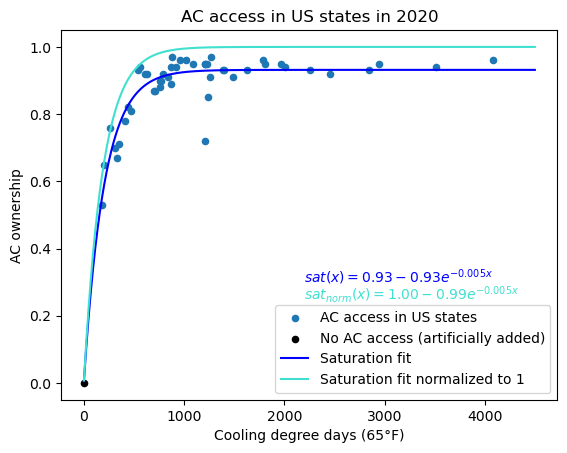

In [ ]:
sat_a, sat_b, sat_c = plot_saturation(normalize=True)

/tmp/ipykernel_1897524/37223927.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ac_data_no_nan.loc[len(ac_data)] = {'GDP': 0, 'avail_pred_new_transf': np.log((1./ac_at_GDP_0)-1.)}
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/matplotlib/text.py:1419: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/matplotlib/text.py:1421: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-p

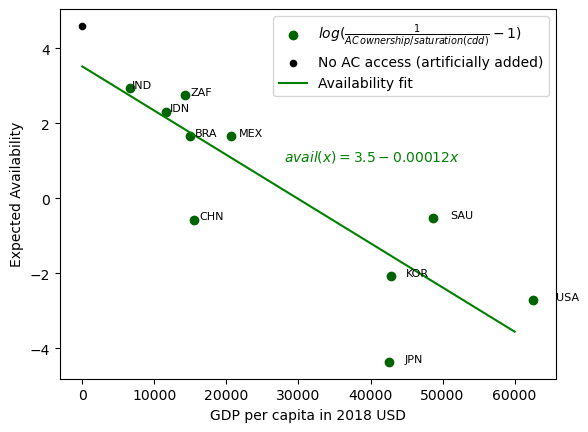

In [ ]:
ac_data['sat_calc_new'] = saturation(ac_data['DD_mean'], sat_a, sat_b, sat_c)
# Compute availability as exposure/saturation
ac_data['avail_pred_new'] = ac_data['AC']/ac_data['sat_calc_new']

# Plot availability curve and data points
plt.figure()
plt.scatter(ac_data['GDP'], np.log((1./ac_data['avail_pred_new'])-1.), label=r'$log( \frac{1}{AC \, ownership /saturation(cdd)}-1)$', color='darkgreen')
ac_at_GDP_0 = 0.01
plt.scatter(0, np.log((1./ac_at_GDP_0)-1.), color='black', marker='o', s=20, 
            label='No AC access (artificially added)')

ac_data['avail_pred_new_transf'] = np.log((1./ac_data['avail_pred_new'])-1.)
ac_data_no_nan = ac_data.dropna()

# Label each point with country name
for txt in ac_data_no_nan['ISO3'].values:
    plt.annotate(txt, (ac_data_no_nan[ac_data_no_nan['ISO3']==txt]['GDP']*1.05, ac_data_no_nan[ac_data_no_nan['ISO3']==txt]['avail_pred_new_transf']), fontsize=8)

def avail_fit(gdp, a, b):
    return (a + b * gdp)

# Add data point at 0 GDP to force asymptotic behavior
ac_data_no_nan.loc[len(ac_data)] = {'GDP': 0, 'avail_pred_new_transf': np.log((1./ac_at_GDP_0)-1.)}

popt, pcov = curve_fit(avail_fit, ac_data_no_nan['GDP'], ac_data_no_nan['avail_pred_new_transf'])
av_a, av_b = popt

# Plot availability curve and data points
gdp_x_fine = np.linspace(0, 60000, 1000)
plt.plot(gdp_x_fine, avail_fit(gdp_x_fine, *popt), label='Availability fit', color='green')
plt.text(28000, 1., f'$avail(x) = {popt[0]:.1f} {popt[1]:.5f}x$', fontsize=10, color='green', fontweight='bold')

plt.xlabel('GDP per capita in 2018 USD')
plt.ylabel('Expected Availability')
plt.legend()
plt.savefig('Figures/exposure_funct_analysis/availability_log_new.png', dpi=300)


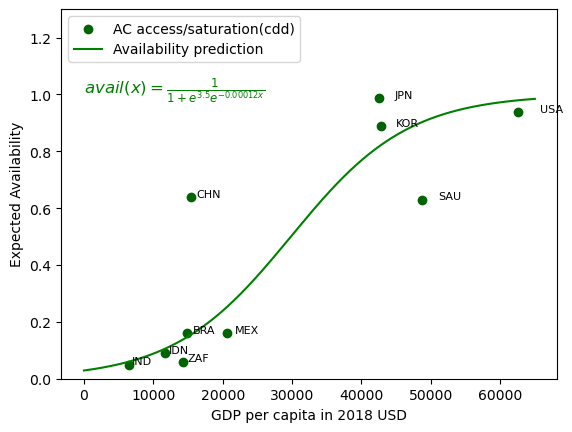

In [ ]:
# Plot availability curve and data points

plt.figure()
plt.scatter(ac_data['GDP'], ac_data['avail_pred_new'], label='AC access/saturation(cdd)', color='darkgreen')

gdp_x_fine = np.linspace(0, 65000, 1000)
plt.plot(gdp_x_fine, availability(gdp_x_fine, av_a, av_b), label='Availability prediction', color='green')
plt.text(0, 1., f'$avail(x) = \\frac{{1}}{{1 + e^{{{av_a:.1f}}}e^{{{av_b:.5f}x}}}}$', fontsize=12, color='green', fontweight='bold')
plt.xlabel('GDP per capita in 2018 USD')
plt.ylabel('Expected Availability')
plt.ylim(0, 1.3)
plt.legend(loc='upper left')

# Label points with country names
for i, txt in enumerate(ac_data['ISO3'].values):
    plt.annotate(txt, (ac_data['GDP'][i]*1.05, ac_data['avail_pred_new'][i]), fontsize=8)

plt.savefig('Figures/exposure_funct_analysis/availability_new.png', dpi=300)


In [ ]:
ac_data

,Unnamed: 0,ISO3,DD_mean,GDP,AC,sat_calc,avail_pred,avail_calc,sat_pred,sat_calc_new,avail_pred_new,avail_pred_new_transf
0,0,AFG,1059.317917,2101.912952,NaN,0.869093,NaN,0.034555,NaN,0.996317,NaN,NaN
1,1,AGO,1726.795211,7016.161826,NaN,0.962426,NaN,0.196498,NaN,0.999892,NaN,NaN
2,2,ALB,387.711453,13583.461649,NaN,0.540385,NaN,0.761299,NaN,0.871403,NaN,NaN
3,3,AND,0.324418,NaN,NaN,0.051576,NaN,NaN,NaN,0.001715,NaN,NaN
4,4,ARE,3875.287384,72981.565419,NaN,0.999324,NaN,1.000000,NaN,1.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
186,186,WSM,2289.772949,6262.421736,NaN,0.986888,NaN,0.154063,NaN,0.999995,NaN,NaN
187,187,YEM,2654.826642,NaN,NaN,0.993375,NaN,NaN,NaN,0.999999,NaN,NaN
188,188,ZAF,927.694056,14270.121191,0.06,0.832561,0.072067,0.806641,0.074383,0.992610,0.060447,2.743643
189,189,ZMB,1567.786753,3494.467915,NaN,0.949415,NaN,0.058113,NaN,0.999750,NaN,NaN


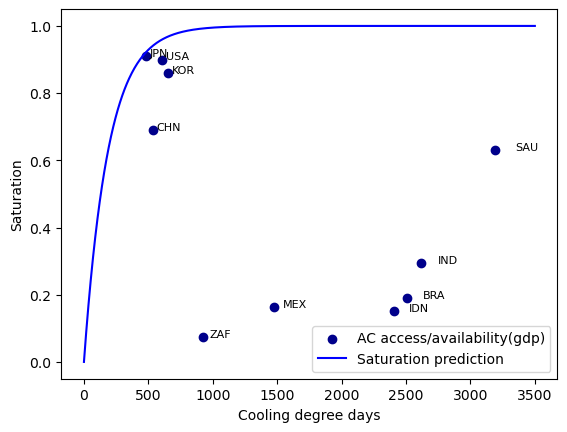

In [ ]:
# Double check saturation
plt.figure()
cdd_x_fine = np.linspace(0, 3500, 1000)
plt.scatter(ac_data['DD_mean'], ac_data['sat_pred'], label='AC access/availability(gdp)', color='darkblue')
plt.plot(cdd_x_fine, saturation(cdd_x_fine, sat_a, sat_b, sat_c),label='Saturation prediction', color='blue')
plt.xlabel('Cooling degree days')
plt.ylabel('Saturation')
# Label each point with country name
for i, txt in enumerate(ac_data['ISO3'].values):
    plt.annotate(txt, (ac_data['DD_mean'][i]*1.05, ac_data['sat_pred'][i]), fontsize=8)
plt.legend()
plt.savefig('Figures/exposure_funct_analysis/saturation_new.png', dpi=300)

saturation parameters:  1.0 1.0 0.005290197941157241


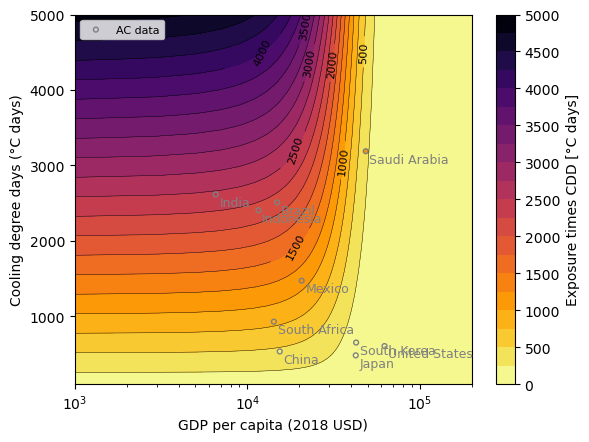

In [ ]:
# Make a contour plot of penetration of air conditioning as a function of GDP per capita and cooling degree days
def exposure_new(gdp, cdd):
    return exposure_function(gdp, av_a, av_b, cdd, sat_a, sat_b, sat_c)

plot_exposure_contour(config, exposure_new, ac_data, x_y_ranges=[[100, 5000, 100],[1000, 200000, 100]], 
                      country=None, name_tag='exposure_contour', control=True)

with open('exposure_function_params.pkl', 'wb') as f:
    pickle.dump({'av_a': av_a, 'av_b': av_b, 'sat_a': sat_a, 'sat_b': sat_b, 'sat_c': sat_c}, f)

print("saturation parameters: ", sat_a, sat_b, sat_c)